In [1]:
# this notebook constructs the time to beaching figure

# we see that more than 1/5 of all undrogued drifters beach within a year of losing their drogue

In [54]:
import numpy as np
import pandas as pd
import geopandas as gpd
#import xarray as xr
import os
import netCDF4 as nc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import scipy.stats as sci_stats
from scipy.ndimage import gaussian_filter

from sklearn.preprocessing import MinMaxScaler

In [2]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [3]:
# load probability of beaching data
os.chdir('/dat1/openonic/Drifters') # directory
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

In [4]:
unique_ids_unbeach = unbeach_undrogued['id'].unique()
print(len(unique_ids_unbeach))

11803


In [5]:
# calcualte the max time_to_beach value for each unique trajectory
unique_ids_beach = beach_undrogued['id'].unique()
print(len(unique_ids_beach))
max_time_trajs = beach_undrogued.groupby('id')['time_to_beach'].max().reset_index()

4252


Text(0.5, 0, 'years')

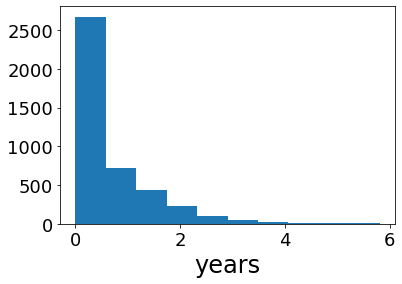

In [6]:
plt.hist(max_time_trajs['time_to_beach']/60/60/24/365)
plt.xlabel('years')

In [7]:
# calculate number that beach within a year
beach_within_yr = max_time_trajs[max_time_trajs['time_to_beach'] < 31536000]

In [8]:
print(f'fraction of total undrogued drifters that beach within a year: {np.round(len(beach_within_yr) / (len(unique_ids_beach) + len(unique_ids_unbeach)),4)}')

fraction of total undrogued drifters that beach within a year: 0.2017


In [9]:
# now let's plot the time to beach heatmap for drifters beaching within a year

In [72]:
# set data greater than a yr to 1 yr
def year_to_beach(df):
    year = 31536000 *2 # Number of seconds in 1 year
    filtered_df = df.copy()
  #  filtered_df['time_to_beach'] = df['time_to_beach'].apply(lambda val: year if val > year else val)  
    filtered_df = df[df['time_to_beach'] < year]
    return filtered_df

In [100]:
time_yr = year_to_beach(beach_undrogued)

In [123]:
# set to months:
time_yr_month = time_yr.copy()
time_yr_month['time_to_beach'] = time_yr['time_to_beach'] / 60 / 60 / 24 / 30.43

In [124]:
undrogued_lats = np.array(time_yr_month['lat'])
undrogued_longs = np.array(time_yr_month['lon'])

In [125]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

yr_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    undrogued_longs,undrogued_lats,values=time_yr_month['time_to_beach'],
    statistic = 'mean', bins = [lon_bins,lat_bins])


In [182]:
def nan_gaussian_filter(values, sigma):
    mask = np.isnan(values)
    values_filled = np.where(mask, np.nanmean(values), values)  # Replace NaNs with the mean of non-NaNs
    filtered = gaussian_filter(values_filled, sigma=sigma)
    filtered[mask] = np.nan  # Restore NaNs
    return filtered

# Apply the custom Gaussian filter
beach_prob_vals_filtered = nan_gaussian_filter(pd.DataFrame(yr_stat).values, sigma=0.75)

In [183]:
np.shape(yr_stat)

(360, 180)

In [184]:
desired_rows = 360
desired_cols = 180
lats_2 = np.linspace(-90,90,desired_cols)
lons_2 = np.linspace(-180, 180, desired_rows)

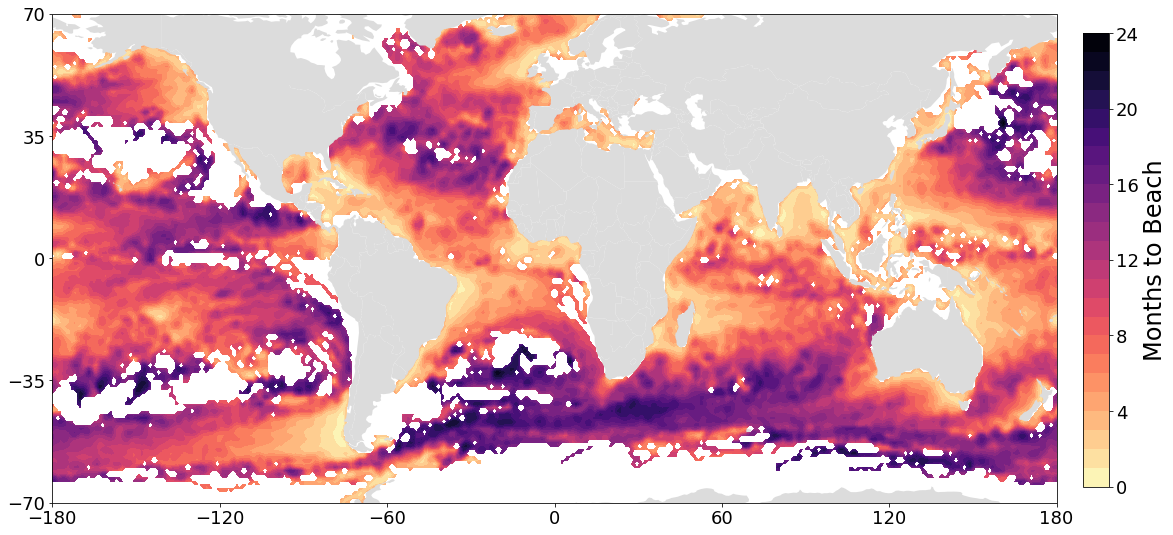

In [185]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# visualize 1 year to beach
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 9),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax1.set_yticks([-70, -35, 0, 35, 70])

im1 = ax1.contourf(lons_2, lats_2, beach_prob_vals_filtered.T, cmap='magma_r', 
                   transform=ccrs.PlateCarree(), vmin=0, vmax=24, levels = 24)

#ax1.set_title('Probability of Beaching')
#ax1.set_xlabel('Longitude')
#ax1.set_ylabel('Latitude')

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Months to Beach')
cbar.set_ticks([0, 4, 8, 12, 16, 20, 24])
im1.set_clim(0, 24)  # This sets the color limits for the ScalarMappable

land.plot(ax=ax1, color='gainsboro', edgecolor='none')
Antarctica.plot(ax=ax1, color='gainsboro', edgecolor='none')
ax1.set_aspect('auto')
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

#plt.savefig('time_to_beach.png', dpi=300)
# Show the plot
plt.show()

In [186]:
# let's look at the vector field of velocity

In [187]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

yr_vector_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    undrogued_longs,undrogued_lats,values=(time_yr_month['ve'],time_yr_month['vn']),
    statistic = 'mean', bins = [lon_bins,lat_bins])

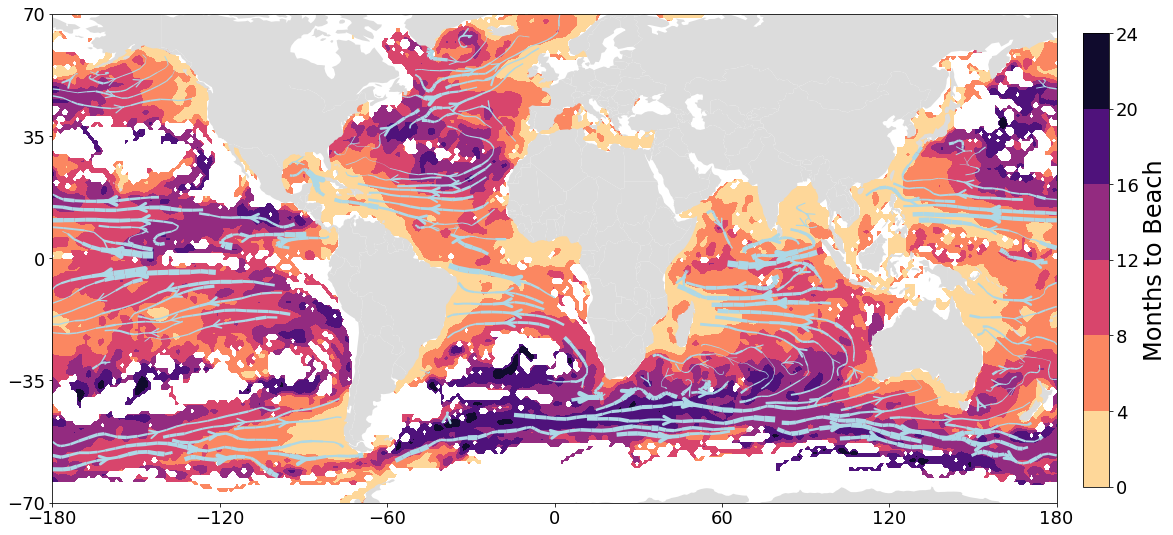

In [207]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# visualize 1 year to beach
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 9),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax1.set_yticks([-70, -35, 0, 35, 70])

im1 = ax1.contourf(lons_2, lats_2, beach_prob_vals_filtered.T, cmap='magma_r', 
                   transform=ccrs.PlateCarree(), vmin=0, vmax=24, levels = 6)

#ax1.set_title('Probability of Beaching')
#ax1.set_xlabel('Longitude')
#ax1.set_ylabel('Latitude')

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Months to Beach')
cbar.set_ticks([0, 4, 8, 12, 16, 20, 24])
im1.set_clim(0, 24)  # This sets the color limits for the ScalarMappable

# Plot wind vectors
Lons_2, Lats_2 = np.meshgrid(lons_2, lats_2)
linewidth = 30 * np.sqrt(yr_vector_stat[0].T**2 + yr_vector_stat[1].T**2) / np.sqrt(
    np.nanmax(yr_vector_stat[0].T)**2 + np.nanmax(yr_vector_stat[1].T)**2)
wind_q_global = ax1.streamplot(Lons_2, Lats_2, yr_vector_stat[0].T, yr_vector_stat[1].T, color='lightblue', 
                               linewidth=linewidth, density = 3, arrowsize = 2, arrowstyle = '->')

land.plot(ax=ax1, color='gainsboro', edgecolor='none')
Antarctica.plot(ax=ax1, color='gainsboro', edgecolor='none')
ax1.set_aspect('auto')
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

#plt.savefig('time_to_beach_vectors.png', dpi=300)
# Show the plot
plt.show()